In [1]:
import pandas as pd 
import wandb
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from sklearn.cluster import KMeans
from sklearn.metrics import balanced_accuracy_score, accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture as GMM
from matplotlib.ticker import FormatStrFormatter, MaxNLocator

import seaborn as sns
sns.set_style("white")
sns.set(context='notebook',
        style='ticks',
        font_scale=1,
        rc={'axes.grid':True,
            'grid.color':'.9',
            'grid.linewidth':0.75})

In [2]:
fontsize = 20
labelsize = 18
lw = 4
markersize = 8

### Rotated MNIST Figure

In [18]:
# ## For target and OOD envs
# def get_results(tag):
#     api = wandb.Api()
#     runs = api.runs("ashwin1996/ood_tl")

#     summary_list, config_list, name_list = [], [], []
#     m_n = []
#     avg_error = []
#     std_error = []
#     ood = []
#     for run in runs: 
#         try:
#             run_tag = run.config['tag'] 
#         except KeyError:
#             run_tag = "None"
#         if run_tag == tag:
#             summary_list.append(run.summary._json_dict)
#             config_list.append(
#                 {k: v for k,v in run.config.items()
#                 if not k.startswith('_')})
#             # print(config_list)
#             name_list.append(run.name)
#             m_n.append(run.config['task']['m_n'])
#             avg_error.append(run.summary['avg_err'])
#             std_error.append(run.summary['std_err'])
#             ood.append(run.config['task']['angle'])

#     runs_df = pd.DataFrame({
#         "ood": ood,
#         "m_n": m_n,
#         "avg_error": avg_error,
#         "std_error": std_error,
#         "summary": summary_list,
#         "config": config_list,
#         "name": name_list
#         })

#     return runs_df

In [19]:
# df_exp = get_results("14_domainbed/rotated_mnist_smallconv")
# df_exp = df_exp.sort_values(by=['ood','m_n']).reset_index(drop=True)
# df_exp.to_csv("results/01_rotated_mnist.csv")

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


In [137]:
df_runs = pd.read_csv("results/01_rotated_mnist.csv")

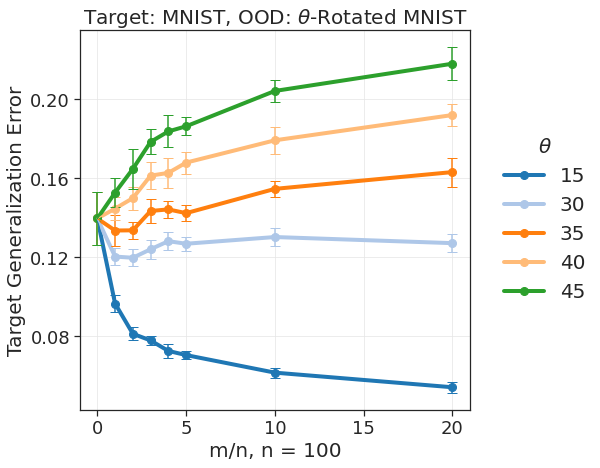

In [147]:
# rotated mnist 
env_list = [15, 30, 35, 40, 45]
reps = 10
n = 100

cmap = [plt.cm.tab20(i) for i in range(len(env_list))]
fig, ax = plt.subplots(figsize=(7, 7))
fontsize = 20
labelsize = 18

for i, env in enumerate(env_list):
    # mnist 
    df = df_runs[df_runs['ood'] == env].reset_index(drop=True)

    m_n = df['m_n'].to_numpy()
    avg_error = df['avg_error'].to_numpy()
    std_error = df['std_error'].to_numpy()
    ci = 1.96 * std_error / np.sqrt(reps)
    ax.plot(m_n, avg_error, color=cmap[i], label=env_list[i], lw=lw, marker='o', markersize=markersize)
    # ax.fill_between(m_n, avg_error  - ci, avg_error + ci, color=cmap[i], alpha=0.2)
    ax.errorbar(m_n, avg_error, yerr=ci, color=cmap[i], solid_capstyle='projecting', capsize=5)
    ax.set_ylabel("Target Generalization Error", fontsize=fontsize)
    
    ax.set_xlabel("m/n, n = {}".format(n), fontsize=fontsize)
    ax.set_title(r"Target: MNIST, OOD: $\theta$-Rotated MNIST", fontsize=fontsize)

    ax.tick_params(axis='x', labelsize=labelsize)
    ax.tick_params(axis='y', labelsize=labelsize)
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_major_locator(MaxNLocator(5))
# mnist 
legend = ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", fontsize=fontsize, title=r"$\theta$", frameon=False)
legend.get_title().set_fontsize(fontsize)

plt.show()

In [148]:
filename = "rotatedMNIST_curves"
fig.savefig("/cis/home/adesilva/ashwin/research/Non-Monotonic-OOD-Risk/figures/{}.eps".format(filename), bbox_inches="tight")

In [6]:
from datahandlers.mnist import RotatedMNISTDataset

0
1
2
3
4
5
6
7
8


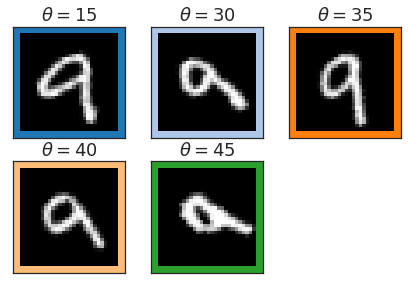

In [7]:
env_list = [15, 30, 35, 40, 45]
cmap = [plt.cm.tab20(i) for i in range(len(env_list))]
fig, axes = plt.subplots(3, 3, figsize=(7, 7))

for i, ax in enumerate(axes.reshape(-1)):
    print(i)
    if i+1 > len(env_list):
        ax.set_visible(False)
        continue
    dataset = RotatedMNISTDataset(angles=[0, env_list[i]])
    targets = np.array(dataset.targets)
    data = dataset.data
    labels = targets[targets[:,0]==1][:, 1]
    data = data[targets[:,0]==1]
    idx = np.where(labels == 9)[0][0]

    pad = np.zeros((32, 32, 3))
    pad[:, :, 0] = cmap[i][0]
    pad[:, :, 1] = cmap[i][1]
    pad[:, :, 2] = cmap[i][2]

    im = np.zeros((28, 28, 3))
    im[:, :, 0] = data[idx].squeeze()
    im[:, :, 1] = data[idx].squeeze()
    im[:, :, 2] = data[idx].squeeze()

    pad[2:-2, 2:-2, :] = im

    ax.imshow(pad)
    ax.grid(False)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.set_title(r"$\theta = {}$".format(env_list[i]), fontsize=labelsize)

In [8]:
filename = "rotatedMNIST_examples"
fig.savefig("/cis/home/adesilva/ashwin/research/Non-Monotonic-OOD-Risk/figures/{}.eps".format(filename), bbox_inches="tight")

### PACS

In [10]:
# api = wandb.Api()
# runs = api.runs("ashwin1996/ood_tl")
# tag = "14_domainbed/3_pacs_wrn16-4"

# summary_list, config_list, name_list = [], [], []
# m_n = []
# n = 0
# m = []
# target = []
# ood = []
# avg_error = []
# std_error = []
# task = []
# for run in runs: 
#     try:
#         run_tag = run.config['tag'] 
#     except KeyError:
#         run_tag = "None"
#     if run_tag == tag:
#         summary_list.append(run.summary._json_dict)
#         config_list.append(
#             {k: v for k,v in run.config.items()
#             if not k.startswith('_')})
#         name_list.append(run.name)
#         m_n.append(run.config['task']['m_n'])
#         m.append(run.summary['m'])
#         n = run.summary['n']
#         target.append(run.config['task']['target_env'])
#         ood.append(run.config['task']['ood_env'])
#         avg_error.append(run.summary['avg_err'])
#         std_error.append(run.summary['std_err'])
#         task.append(run.config['task']['target'])

# runs_df = pd.DataFrame({
#     "m_n": m_n,
#     "m": m,
#     "avg_error": avg_error,
#     "std_error": std_error,
#     "task": task,
#     "target": target,
#     "ood": ood,
#     "summary": summary_list,
#     "config": config_list,
#     "name": name_list
#     })
# runs_df = runs_df.sort_values(by=['target','ood','m_n']).reset_index(drop=True)

In [11]:
# runs_df.to_csv("results/02_pacs.csv")

In [150]:
df_runs = pd.read_csv("results/02_pacs.csv")

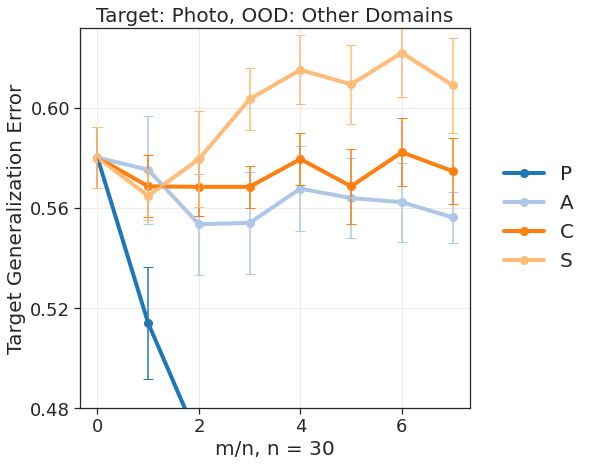

In [151]:
# PACS
env_list = ["P", "A", "C", "S"]
env_long_list = ["Photo", "Art", "Cartoon", "Sketch"]
n = 30
reps = 10

cmap = [plt.cm.tab20(i) for i in range(len(env_list))]
fig, ax = plt.subplots(figsize=(7, 7))
fontsize = 20
labelsize = 18

for i, env in enumerate(env_list):
    df = df_runs[df_runs['ood'] == env].reset_index(drop=True)

    m_n = df['m_n'].to_numpy()
    avg_error = df['avg_error'].to_numpy()
    std_error = df['std_error'].to_numpy()
    ci = 1.96 * std_error / np.sqrt(reps)
    m_n = m_n[:8]
    avg_error = avg_error[:8]
    ci = ci[:8]
    ax.plot(m_n, avg_error, color=cmap[i], label=env_list[i], lw=lw, marker='o', markersize=markersize)
    # ax.fill_between(m_n, avg_error  - ci, avg_error + ci, color=cmap[i], alpha=0.2)
    ax.errorbar(m_n, avg_error, yerr=ci, color=cmap[i], solid_capstyle='projecting', capsize=5)
    ax.set_ylabel("Target Generalization Error", fontsize=fontsize)
    ax.set_ylim([0.48, avg_error.max()+0.01])
    
    ax.set_xlabel("m/n, n = {}".format(n), fontsize=fontsize)
    ax.set_title(r"Target: Photo, OOD: Other Domains", fontsize=fontsize)

    ax.tick_params(axis='x', labelsize=labelsize)
    ax.tick_params(axis='y', labelsize=labelsize)
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_major_locator(MaxNLocator(5))

# pacs 
legend = ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", fontsize=fontsize, frameon=False)
legend.get_title().set_fontsize(fontsize)


In [152]:
filename = "PACS_curves"
fig.savefig("/cis/home/adesilva/ashwin/research/Non-Monotonic-OOD-Risk/figures/{}.eps".format(filename), bbox_inches="tight")

In [26]:
from datahandlers.pacs import PACSHandler
import hydra
import omegaconf

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


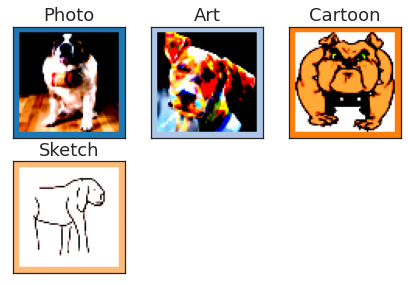

In [28]:
env_list = ["P", "A", "C", "S"]
env_long_list = ["Photo", "Art", "Cartoon", "Sketch"]
cmap = [plt.cm.tab20(i) for i in range(len(env_list))]
fig, axes = plt.subplots(3, 3, figsize=(7, 7))

for i, ax in enumerate(axes.reshape(-1)):
    if i+1 > len(env_list):
        ax.set_visible(False)
        continue

    cfg = omegaconf.OmegaConf.load('/cis/home/adesilva/ashwin/research/ood-tl/config/conf.yaml')
    cfg.task.target_env = "P"
    cfg.task.ood_env = env_list[i]
    cfg.task.task_map = [[0,1,4]]
    cfg.task.n=20
    cfg.task.m_n=1
    cfg.hp.bs=1

    dataset = PACSHandler(cfg)
    dataset.sample_data(1996)

    targets = np.array(dataset.comb_trainset.targets)
    data = dataset.comb_trainset.data
    labels = targets[targets[:,0]==1][:, 1]
    data = data[targets[:,0]==1]
    dataset.comb_trainset.data = data
    if i == 0:
        idx = np.where(labels == 0)[0][1]
    elif i == 1:
        idx = np.where(labels == 0)[0][1]
    else:
        idx = np.where(labels == 0)[0][0]

    pad = np.zeros((72, 72, 3))
    pad[:, :, 0] = cmap[i][0]
    pad[:, :, 1] = cmap[i][1]
    pad[:, :, 2] = cmap[i][2]

    im = dataset.comb_trainset.__getitem__(idx)[0].numpy().transpose(1, 2, 0)

    pad[4:-4, 4:-4, :] = im

    ax.imshow(pad)
    ax.grid(False)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.set_title("{}".format(env_long_list[i]), fontsize=labelsize)

In [29]:
filename = "PACS_examples"
fig.savefig("/cis/home/adesilva/ashwin/research/Non-Monotonic-OOD-Risk/figures/{}.eps".format(filename), bbox_inches="tight")

### Domain-Net

In [153]:
import glob

In [154]:
def get_results(id):
    mval = []
    err = []
    std = []

    for fname in glob.glob("/cis/home/adesilva/ashwin/research/ood-tl/logs/05_ood/0{}_domain_net/*".format(id)):
        with open(fname, "r") as fp:
            cont = fp.readlines()

        cfg = eval(cont[0])
        dictt = eval(cont[-1])

        mval.append(cfg['task']['m_n'])
        err.append(dictt['avg_err'])
        std.append(dictt['std_err'])

    print(mval)
    print(err)
    err = np.array(err)
    mval = np.array(mval)
    std = np.array(std)

    ind = np.argsort(mval)
    mval = mval[ind]
    std = std[ind]
    err = err[ind]

    return err, std, mval

[1, 4, 8, 9, 0, 3, 6, 7, 5, 2, 10, 0.25, 0.5]
[0.2202, 0.1296, 0.1235, 0.1114, 0.2518, 0.1436, 0.1248, 0.1202, 0.1309, 0.1638, 0.1111, 0.2166, 0.2114]
[0.25, 4, 9, 2, 6, 3, 5, 7, 1, 0, 10, 0.5, 8]
[0.2248, 0.1912, 0.2065, 0.2033, 0.1863, 0.1902, 0.1925, 0.1886, 0.1896, 0.2518, 0.1961, 0.2169, 0.2192]
[0, 9, 3, 1, 7, 0.5, 5, 0.25, 10, 6, 4, 2, 8]
[0.2518, 0.172, 0.1906, 0.2241, 0.1743, 0.2189, 0.1912, 0.2098, 0.1619, 0.1674, 0.1808, 0.2303, 0.1573]
[1, 4, 0.25, 3, 8, 10, 5, 9, 7, 2, 6, 0.5, 0]
[0.2182, 0.2121, 0.2218, 0.2254, 0.2365, 0.2365, 0.2293, 0.2365, 0.2365, 0.2257, 0.2345, 0.2179, 0.2518]
[8, 3, 0.5, 5, 7, 0.25, 6, 9, 10, 0, 2, 4, 1]
[0.1948, 0.1889, 0.2114, 0.1896, 0.1938, 0.2169, 0.1831, 0.184, 0.1987, 0.2518, 0.2134, 0.1928, 0.2134]


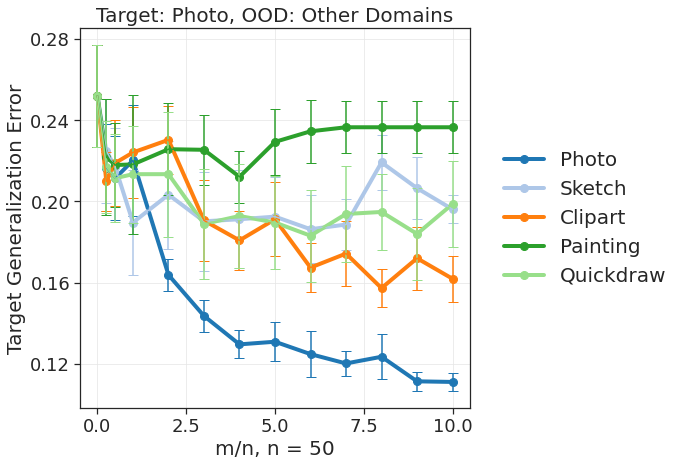

In [155]:
env_list = ["Photo", "Sketch", "Clipart", "Infograph", "Painting", "Quickdraw"]

cmap = [plt.cm.tab20(i) for i in range(len(env_list))]
fig, ax = plt.subplots(figsize=(7, 7))
fontsize = 20
labelsize = 18
n = 50

for i, env in enumerate(env_list):
    if env == "Infograph":
        continue
    avg_error, std_error, m_n = get_results(i)
    ci = 1.96 * std_error / np.sqrt(10)
    ax.plot(m_n, avg_error, color=cmap[i], label=env_list[i], lw=lw, marker='o', markersize=markersize)
    # ax.fill_between(m_n, avg_error  - ci, avg_error + ci, color=cmap[i], alpha=0.2)
    ax.errorbar(m_n, avg_error, yerr=ci, color=cmap[i], solid_capstyle='projecting', capsize=5)
    ax.set_ylabel("Target Generalization Error", fontsize=fontsize)
    # ax.set_ylim([0.45, avg_error[:6].max()+0.01])
    
    ax.set_xlabel("m/n, n = {}".format(n), fontsize=fontsize)
    ax.set_title(r"Target: Photo, OOD: Other Domains", fontsize=fontsize)

    ax.tick_params(axis='x', labelsize=labelsize)
    ax.tick_params(axis='y', labelsize=labelsize)
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_major_locator(MaxNLocator(5))

# pacs 
legend = ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", fontsize=fontsize, frameon=False)
legend.get_title().set_fontsize(fontsize)


In [156]:
filename = "DomainNet_curves"
fig.savefig("/cis/home/adesilva/ashwin/research/Non-Monotonic-OOD-Risk/figures/{}.eps".format(filename), bbox_inches="tight")

In [49]:
from skimage.io import imread
from skimage.transform import resize

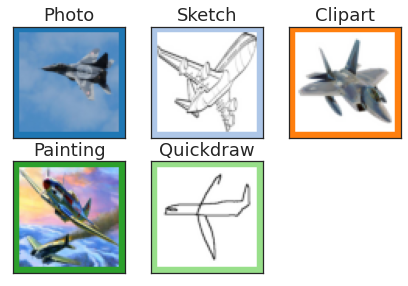

In [60]:
env_list = [
    "Photo", 
    "Sketch", 
    "Clipart", 
    # "Infograph", 
    "Painting", 
    "Quickdraw"
    ]
cmap = [plt.cm.tab20(i) for i in range(len(env_list)+1)]
del cmap[3]
fig, axes = plt.subplots(3, 3, figsize=(7, 7))

filenames = [
    'DomainNet_env4real_23_idx1778_class4.png',
    'DomainNet_env5sketch_2_idx904_class4.png',
    'DomainNet_env0clipart_9_idx455_class4.png',
    # 'DomainNet_env1infograph_6_idx496_class4.png',
    'DomainNet_env2painting_34_idx891_class4.png',
    'DomainNet_env3quickdraw_8_idx2376_class4.png'
]

axes = axes.reshape(-1)
for i, ax in enumerate(axes.reshape(-1)):
    if i+1 > len(env_list):
        ax.set_visible(False)
        continue
    
    im = imread("/cis/home/adesilva/ashwin/research/Non-Monotonic-OOD-Risk/assets/"+filenames[i])
    im = resize(im, (64, 64), anti_aliasing=True)

    pad = np.zeros((72, 72, 3))
    pad[:, :, 0] = cmap[i][0]
    pad[:, :, 1] = cmap[i][1]
    pad[:, :, 2] = cmap[i][2]

    pad[4:-4, 4:-4, :] = im

    ax.imshow(pad)
    ax.grid(False)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.set_title("{}".format(env_list[i]), fontsize=labelsize)

In [62]:
filename = "DomainNet_examples"
fig.savefig("/cis/home/adesilva/ashwin/research/Non-Monotonic-OOD-Risk/figures/{}.eps".format(filename), bbox_inches="tight")

### Effect of Pretraining

In [63]:
# api = wandb.Api()
# runs = api.runs("ashwin1996/ood_tl")
# tag = "15_pretraining/wrn10_2/alt100epochs"

# summary_list, config_list, name_list = [], [], []
# m_n = []
# n = 0
# m = []
# target = []
# ood = []
# ptw = []
# avg_error = []
# std_error = []
# for run in runs: 
#     try:
#         run_tag = run.config['tag'] 
#     except KeyError:
#         run_tag = "None"
#     if run_tag == tag:
#         summary_list.append(run.summary._json_dict)
#         config_list.append(
#             {k: v for k,v in run.config.items()
#             if not k.startswith('_')})
#         name_list.append(run.name)
#         m_n.append(run.config['task']['m_n'])
#         m.append(run.summary['m'])
#         n = run.summary['n']
#         target.append(run.config['task']['target'])
#         ood.append(run.config['task']['ood'][0])
#         avg_error.append(run.summary['avg_err'])
#         std_error.append(run.summary['std_err'])
#         ptw.append(run.config['ptw'])

In [64]:
# runs_df = pd.DataFrame({
#     "m_n": m_n,
#     "m": m,
#     "avg_error": avg_error,
#     "std_error": std_error,
#     "target": target,
#     "ood": ood,
#     "ptw": np.array(ptw, dtype='int'),
#     "summary": summary_list,
#     "config": config_list,
#     "name": name_list
#     })
# runs_df = runs_df.sort_values(by=['ptw','target','ood', 'm_n']).reset_index(drop=True)

In [67]:
# api = wandb.Api()
# runs = api.runs("ashwin1996/ood_tl")
# tag = "15_pretraining/wrn10_2"

# summary_list, config_list, name_list = [], [], []
# m_n = []
# n = 0
# m = []
# target = []
# ood = []
# ptw = []
# avg_error = []
# std_error = []
# for run in runs: 
#     try:
#         run_tag = run.config['tag'] 
#     except KeyError:
#         run_tag = "None"
#     if run_tag == tag and run.config['ptw'] == 0:
#         summary_list.append(run.summary._json_dict)
#         config_list.append(
#             {k: v for k,v in run.config.items()
#             if not k.startswith('_')})
#         name_list.append(run.name)
#         m_n.append(run.config['task']['m_n'])
#         m.append(run.summary['m'])
#         n = run.summary['n']
#         target.append(run.config['task']['target'])
#         ood.append(run.config['task']['ood'][0])
#         avg_error.append(run.summary['avg_err'])
#         std_error.append(run.summary['std_err'])
#         ptw.append(run.config['ptw'])

In [68]:
# runs_df1 = pd.DataFrame({
#     "m_n": m_n,
#     "m": m,
#     "avg_error": avg_error,
#     "std_error": std_error,
#     "target": target,
#     "ood": ood,
#     "ptw": np.array(ptw, dtype='int'),
#     "summary": summary_list,
#     "config": config_list,
#     "name": name_list
#     })
# runs_df1 = runs_df1.sort_values(by=['ptw','target','ood', 'm_n']).reset_index(drop=True)

In [69]:
# runs_df = runs_df.append(runs_df1, ignore_index=True)
# runs_df = runs_df.sort_values(by=['ptw','target','ood', 'm_n']).reset_index(drop=True)
# runs_df.to_csv("results/03_effect_of_pretraining.csv")

/tmp/ipykernel_7605/1488319548.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  runs_df = runs_df.append(runs_df1, ignore_index=True)


In [117]:
# api = wandb.Api()
# runs = api.runs("ashwin1996/ood_tl")
# tag = "15_pretraining/wrn10_2/aug"

# summary_list, config_list, name_list = [], [], []
# m_n = []
# n = 0
# m = []
# target = []
# ood = []
# ptw = []
# avg_error = []
# std_error = []
# for run in runs: 
#     try:
#         run_tag = run.config['tag'] 
#     except KeyError:
#         run_tag = "None"
#     if run_tag == tag:
#         summary_list.append(run.summary._json_dict)
#         config_list.append(
#             {k: v for k,v in run.config.items()
#             if not k.startswith('_')})
#         name_list.append(run.name)
#         m_n.append(run.config['task']['m_n'])
#         m.append(run.summary['m'])
#         n = run.summary['n']
#         target.append(run.config['task']['target'])
#         ood.append(run.config['task']['ood'][0])
#         avg_error.append(run.summary['avg_err'])
#         std_error.append(run.summary['std_err'])
#         ptw.append(run.config['ptw'])

In [119]:
# runs_df = pd.DataFrame({
#     "m_n": m_n,
#     "m": m,
#     "avg_error": avg_error,
#     "std_error": std_error,
#     "target": target,
#     "ood": ood,
#     "augment": np.ones(len(m_n)).astype('int'),
#     "ptw": np.array(ptw, dtype='int'),
#     "summary": summary_list,
#     "config": config_list,
#     "name": name_list
#     })
# runs_df = runs_df.sort_values(by=['ptw','target','ood', 'm_n']).reset_index(drop=True)

In [120]:
# runs_df.to_csv("results/04_effect_of_augmentation.csv")

In [161]:
runs_df = pd.read_csv("results/03_effect_of_pretraining.csv")
df_vanilla = runs_df[runs_df['ptw'] == 0].reset_index(drop=True)
df_pt = runs_df[runs_df['ptw'] == 1].reset_index(drop=True)
df_aug = pd.read_csv("results/04_effect_of_augmentation.csv")
dfs = [df_vanilla, df_aug, df_pt]

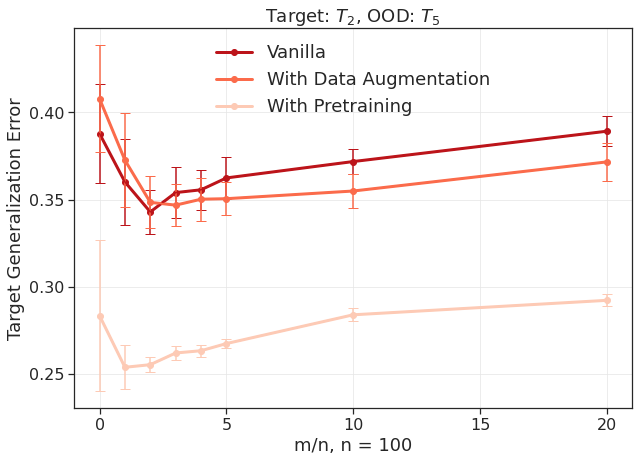

In [162]:
label_list = ["Vanilla", "With Data Augmentation", "With Pretraining"]
cmap = [plt.cm.Reds_r(i) for i in np.linspace(0.2, 0.8, 3)]
fig, ax = plt.subplots(figsize=(10, 7))
fontsize = 18
labelsize = 16
reps = 10
n = 100

for i, df in enumerate(dfs):
    m_n = df['m'].to_numpy() / n
    avg_error = df['avg_error'].to_numpy()
    std_error = df['std_error'].to_numpy()
    ci = 1.96 * std_error / np.sqrt(reps)
    ax.plot(m_n, avg_error , color=cmap[i], label=label_list[i], lw=lw, marker='o', markersize=markersize)
    # ax.fill_between(m_n, avg_error  - ci, avg_error + ci, color=cmap[i], alpha=0.2)
    ax.errorbar(m_n, avg_error, yerr=ci, color=cmap[i], solid_capstyle='projecting', capsize=5)
    ax.set_ylabel("Target Generalization Error", fontsize=fontsize)
    ax.set_xlabel("m/n, n = {}".format(n), fontsize=fontsize)
    ax.set_title(r"Target: $T_2$, OOD: $T_5$", fontsize=fontsize)
    # ax.set_title(r"BlurredCIFAR10, Target: Task {}, OOD: $\sigma$-blurred Task {}".format(task, task), fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=labelsize)
    ax.tick_params(axis='y', labelsize=labelsize)
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_major_locator(MaxNLocator(5))
ax.legend(fontsize=fontsize, frameon=False)

In [163]:
filename = "effect_of_pt_aug"
fig.savefig("/cis/home/adesilva/ashwin/research/Non-Monotonic-OOD-Risk/figures/{}.eps".format(filename), bbox_inches="tight")

### PACS Task Agnostic, Naive Task-Aware, Optimal Task-Aware

In [90]:
# ## For target and OOD envs
# def get_results(tag):
#     api = wandb.Api()
#     runs = api.runs("ashwin1996/ood_tl")

#     summary_list, config_list, name_list = [], [], []
#     m_n = []
#     avg_error = []
#     std_error = []
#     target = []
#     ood = []
#     for run in runs: 
#         try:
#             run_tag = run.config['tag'] 
#         except KeyError:
#             run_tag = "None"
#         if run_tag == tag:
#             summary_list.append(run.summary._json_dict)
#             config_list.append(
#                 {k: v for k,v in run.config.items()
#                 if not k.startswith('_')})
#             name_list.append(run.name)
#             m_n.append(run.config['task']['m_n'])
#             avg_error.append(run.summary['avg_err'])
#             std_error.append(run.summary['std_err'])
#             target.append(run.config['task']['target_env'])
#             ood.append(run.config['task']['ood_env'])

#     runs_df = pd.DataFrame({
#         "target": target,
#         "ood": ood,
#         "m_n": m_n,
#         "avg_error": avg_error,
#         "std_error": std_error,
#         "summary": summary_list,
#         "config": config_list,
#         "name": name_list
#         })

#     return runs_df

In [91]:
# df_naive = get_results("16_task_aware/pacs_naive")
# df_agnostic = get_results("14_domainbed/3_pacs_wrn16-4")
# df_opt = get_results("16_task_aware/pacs_opt")

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


In [116]:
# df_naive.to_csv("/cis/home/adesilva/ashwin/research/Non-Monotonic-OOD-Risk/results/PCAS_PvS_naive.csv")
# df_agnostic.to_csv("/cis/home/adesilva/ashwin/research/Non-Monotonic-OOD-Risk/results/PCAS_PvS_agnostic.csv")
# df_opt.to_csv("/cis/home/adesilva/ashwin/research/Non-Monotonic-OOD-Risk/results/PCAS_PvS_opt.csv")

In [260]:
df_agnostic = pd.read_csv("results/PCAS_PvS_agnostic.csv")
df_naive = pd.read_csv("results/PCAS_PvS_naive.csv")
df_opt = pd.read_csv("results/PCAS_PvS_opt2.csv")

In [261]:
dfs = [df_agnostic, df_naive, df_opt]
colors = ["red", "orange", "green"]

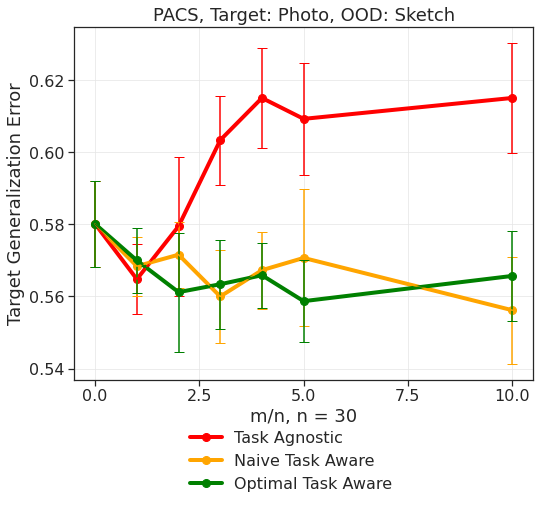

In [264]:
fig, ax = plt.subplots(figsize=(7,7))
fontsize = 18
labelsize = 16
labels = ["Task Agnostic", "Naive Task Aware", "Optimal Task Aware"]
n = 30

df_agnostic = df_agnostic.sort_values(by=['target', 'ood', 'm_n']).reset_index(drop=True)

indices = np.array([0,1,2,3,4,5,10])
for k, df in enumerate(dfs):
    df = df.sort_values(by=['target', 'ood', 'm_n']).reset_index(drop=True)
    i='P'
    j='S'
    
    avg_err_ag = np.array(df_agnostic[(df_agnostic["target"]==i) & (df_agnostic["ood"]==j)]["avg_error"])
    std_errs_ag = np.array(df_agnostic[(df_agnostic["target"]==i) & (df_agnostic["ood"]==j)]["std_error"])
    avg_err = np.array(df[(df["target"]==i) & (df["ood"]==j)]["avg_error"])
    std_errs = np.array(df[(df["target"]==i) & (df["ood"]==j)]["std_error"])
    m_n = np.array(df[(df["target"]==i) & (df["ood"]==j)]["m_n"])

    if k != 2:
        avg_err = avg_err[indices]
        std_errs = std_errs[indices]
        m_n = m_n[indices]

    avg_err[0] = avg_err_ag[0]
    std_errs[0] = std_errs_ag[0]
    
    ci = 1.96 * std_errs.astype('float')/np.sqrt(10)
    ax.plot(m_n, avg_err, c=colors[k], lw=lw, label=labels[k], marker='o', markersize=markersize)
    ax.errorbar(m_n, avg_err, yerr=ci, color=colors[k], solid_capstyle='projecting', capsize=5)
    # ax.fill_between(m_n, avg_err-ci, avg_err+ci, color=colors[k], alpha=0.2)
    ax.set_ylabel("Target Error")
    ax.set_xlabel("m/n, n=30")

    ax.set_ylabel("Target Generalization Error", fontsize=fontsize)
    ax.set_xlabel("m/n, n = {}".format(n), fontsize=fontsize)
    ax.set_title("PACS, Target: Photo, OOD: Sketch", fontsize=fontsize)
    
    ax.tick_params(axis='x', labelsize=labelsize)
    ax.tick_params(axis='y', labelsize=labelsize)
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_major_locator(MaxNLocator(5))

left  = 0.07  # the left side of the subplots of the figure
right = 0.98    # the right side of the subplots of the figure
bottom = 0.25   # the bottom of the subplots of the figure
top = 0.95      # the top of the subplots of the figure
wspace = 0.27   # the amount of width reserved for blank space between subplots
hspace = 0.27   # the amount of height reserved for white space between subplots
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

legend = fig.legend(bbox_to_anchor=(0.5, 0), loc=8, frameon=False, fontsize=labelsize)
legend.get_title().set_fontsize(fontsize)

In [265]:
filename = "PACS_agnostic_naive_opt"
fig.savefig("/cis/home/adesilva/ashwin/research/Non-Monotonic-OOD-Risk/figures/{}.eps".format(filename), bbox_inches="tight")

### Rotated CIFAR-10

In [164]:
# api = wandb.Api()
# runs = api.runs("ashwin1996/ood_tl")
# tag = "06_rotated_cifar10/wrn-10-2"

# summary_list, config_list, name_list = [], [], []
# m_n = []
# avg_error = []
# std_error = []
# angle = []
# for run in runs: 
#     try:
#         run_tag = run.config['tag'] 
#     except KeyError:
#         run_tag = "None"
#     if run_tag == tag:
#         summary_list.append(run.summary._json_dict)
#         config_list.append(
#             {k: v for k,v in run.config.items()
#             if not k.startswith('_')})
#         name_list.append(run.name)
#         m_n.append(run.config['task']['m_n'])
#         avg_error.append(run.summary['avg_err'])
#         std_error.append(run.summary['std_err'])
#         angle.append(run.config['task']['ood_env'])

In [165]:
# runs_df = pd.DataFrame({
#     "m_n": m_n,
#     "avg_error": avg_error,
#     "std_error": std_error,
#     "angle":angle,
#     "summary": summary_list,
#     "config": config_list,
#     "name": name_list
#     })
# runs_df = runs_df.sort_values(by=['angle', 'm_n']).reset_index(drop=True)

In [166]:
# runs_df.to_csv("results/06_rotated_cifar10.csv")

In [247]:
runs_df = pd.read_csv("results/06_rotated_cifar10.csv")

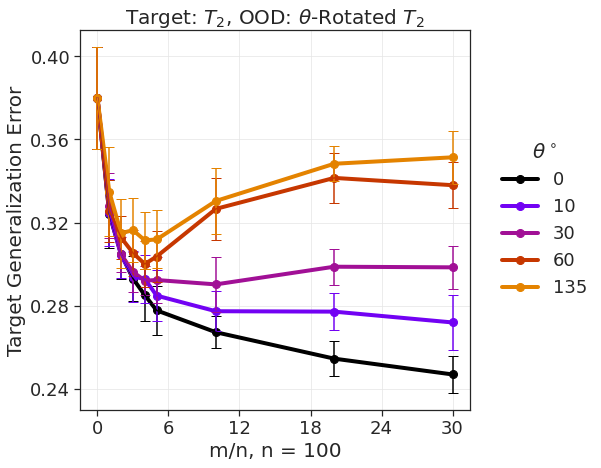

In [248]:
angle_list = [0,  10,  30, 60, 135]
cmap = [plt.cm.gnuplot(i) for i in np.linspace(0,0.8,len(angle_list))]
fig, ax = plt.subplots(figsize=(7, 7))
reps = 10
n = 100

for i, angle in enumerate(angle_list):
    df = runs_df[runs_df['angle'] == angle].reset_index(drop=True)
    m_n = df['m_n'].to_numpy()[:-1]
    avg_error = df['avg_error'].to_numpy()[:-1]
    std_error = df['std_error'].to_numpy()[:-1]
    ci = 1.96 * std_error / np.sqrt(10)
    ax.plot(m_n, avg_error , color=cmap[i], label=angle, lw=lw, marker='o', markersize=markersize)
    # ax.fill_between(m_n, avg_error  - ci, avg_error + ci, color=cmap[i], alpha=0.2)
    ax.errorbar(m_n, avg_error, yerr=ci, color=cmap[i], solid_capstyle='projecting', capsize=5)
    ax.set_ylabel("Target Generalization Error", fontsize=fontsize)
    ax.set_xlabel("m/n, n = {}".format(n), fontsize=fontsize)
    ax.set_title(r"Target: $T_2$, OOD: $\theta$-Rotated $T_2$", fontsize=fontsize)
    # ax.set_title("SplitCINIC Task {}, Target: CIFAR, OOD: ImageNet".format(task+1), fontsize=fontsize)
    # ax.set_title(r"BlurredCIFAR10, Target: Task {}, OOD: $\sigma$-blurred Task {}".format(task, task), fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=labelsize)
    ax.tick_params(axis='y', labelsize=labelsize)
    ax.xaxis.set_major_locator(MaxNLocator(6))
    ax.yaxis.set_major_locator(MaxNLocator(5))
legend = ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", frameon=False, title=r"$\theta^\circ$", fontsize=labelsize)
legend.get_title().set_fontsize(fontsize)

In [249]:
filename = "RotatedCIFAR10_curves"
fig.savefig("/cis/home/adesilva/ashwin/research/Non-Monotonic-OOD-Risk/figures/{}.eps".format(filename), bbox_inches="tight")

### Blurred CIFAR-10

In [213]:
# api = wandb.Api()
# runs = api.runs("ashwin1996/ood_tl")
# tag = "07_blurred_cifar10_wrn/task_agnostic"

# summary_list, config_list, name_list = [], [], []
# m_n = []
# sigma = []
# avg_error = []
# std_error = []
# task = []
# for run in runs: 
#     try:
#         run_tag = run.config['tag'] 
#     except KeyError:
#         run_tag = "None"
#     if run_tag == tag:
#         summary_list.append(run.summary._json_dict)
#         config_list.append(
#             {k: v for k,v in run.config.items()
#             if not k.startswith('_')})
#         name_list.append(run.name)
#         m_n.append(run.config['task']['m_n'])
#         sigma.append(run.config['task']['sigma'])
#         avg_error.append(run.summary['avg_err'])
#         std_error.append(run.summary['std_err'])
#         task.append(run.config['task']['target'])

# runs_df = pd.DataFrame({
#     "m_n": m_n,
#     "avg_error": avg_error,
#     "std_error": std_error,
#     "task": task,
#     "sigma": sigma,
#     "summary": summary_list,
#     "config": config_list,
#     "name": name_list
#     })

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


In [223]:
# runs_df = runs_df.sort_values(by=['task', 'sigma' ,'m_n']).reset_index(drop=True)

In [224]:
# runs_df.to_csv("results/07_blurred_cifar10.csv")

In [251]:
runs_df = pd.read_csv("results/07_blurred_cifar10.csv")

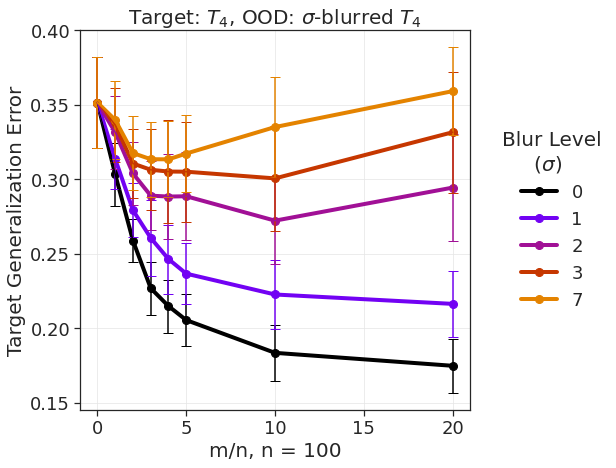

In [257]:
task = 3
sigma_list = [0,1,2,3,7]
cmap = [plt.cm.gnuplot(i) for i in np.linspace(0, 0.8, len(sigma_list))]
fig, ax = plt.subplots(figsize=(7, 7))
dft = runs_df[runs_df['task'] == task].reset_index(drop=True)
reps = 10

for i, sigma in enumerate(sigma_list):
    df = dft[dft['sigma'] == sigma].reset_index(drop=True)
    m_n = df['m_n'].to_numpy()
    avg_error = df['avg_error'].to_numpy()
    std_error = df['std_error'].to_numpy()
    ci = 1.96 * std_error / np.sqrt(reps)
    ax.plot(m_n, avg_error , color=cmap[i], label=sigma, lw=lw, marker='o', markersize=markersize)
    # ax.fill_between(m_n, avg_error  - ci, avg_error + ci, color=cmap[i], alpha=0.2)
    ax.errorbar(m_n, avg_error, yerr=ci, color=cmap[i], solid_capstyle='projecting', capsize=5)
    ax.set_ylabel("Target Generalization Error", fontsize=fontsize)
    ax.set_xlabel("m/n, n = 100", fontsize=fontsize)
    ax.set_title(r"Target: $T_4$, OOD: $\sigma$-blurred $T_4$".format(task, task), fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=labelsize)
    ax.tick_params(axis='y', labelsize=labelsize)
legend = ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", fontsize=labelsize, frameon=False, title="Blur Level\n     ($\sigma$)")
legend.get_title().set_fontsize(fontsize)

In [259]:
filename = "BlurredCIFAR10_curves"
fig.savefig("/cis/home/adesilva/ashwin/research/Non-Monotonic-OOD-Risk/figures/{}.eps".format(filename), bbox_inches="tight")

### Split-CIFAR-10 Matrix

In [266]:
## For Split-CIFAR10
def get_results(tag):
    api = wandb.Api()
    runs = api.runs("ashwin1996/ood_tl")

    summary_list, config_list, name_list = [], [], []
    m_n = []
    avg_error = []
    std_error = []
    target = []
    ood = []
    gpu = []
    for run in runs: 
        try:
            run_tag = run.config['tag'] 
        except KeyError:
            run_tag = "None"
        if run_tag == tag:
            summary_list.append(run.summary._json_dict)
            config_list.append(
                {k: v for k,v in run.config.items()
                if not k.startswith('_')})
            name_list.append(run.name)
            m_n.append(run.config['task']['m_n'])
            avg_error.append(run.summary['avg_err'])
            std_error.append(run.summary['std_err'])
            target.append(run.config['task']['target'])
            ood.append(run.config['task']['ood'][0])
            gpu.append(run.config['device'])

    runs_df = pd.DataFrame({
        "target": target,
        "ood": ood,
        "m_n": m_n,
        "avg_error": avg_error,
        "std_error": std_error,
        "device": gpu,
        "summary": summary_list,
        "config": config_list,
        "name": name_list
        })

    return runs_df

In [267]:
df_agnostic = get_results("04_transfer_exps_cifar10/wrn")
df_naive = get_results("04_transfer_exps_cifar10/wrn/naive_aware")
df_opt = get_results("16_task_aware/cifar10/opt")

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


In [268]:
df_agnostic.to_csv("results/09_wrn_cifar_agnostic.csv")
df_naive.to_csv("results/09_wrn_cifar_naive.csv")
df_opt.to_csv("results/09_wrn_cifar_opt.csv")

In [272]:
dfs = [df_agnostic, df_naive, df_opt]
colors = ["red", "orange", "green"]

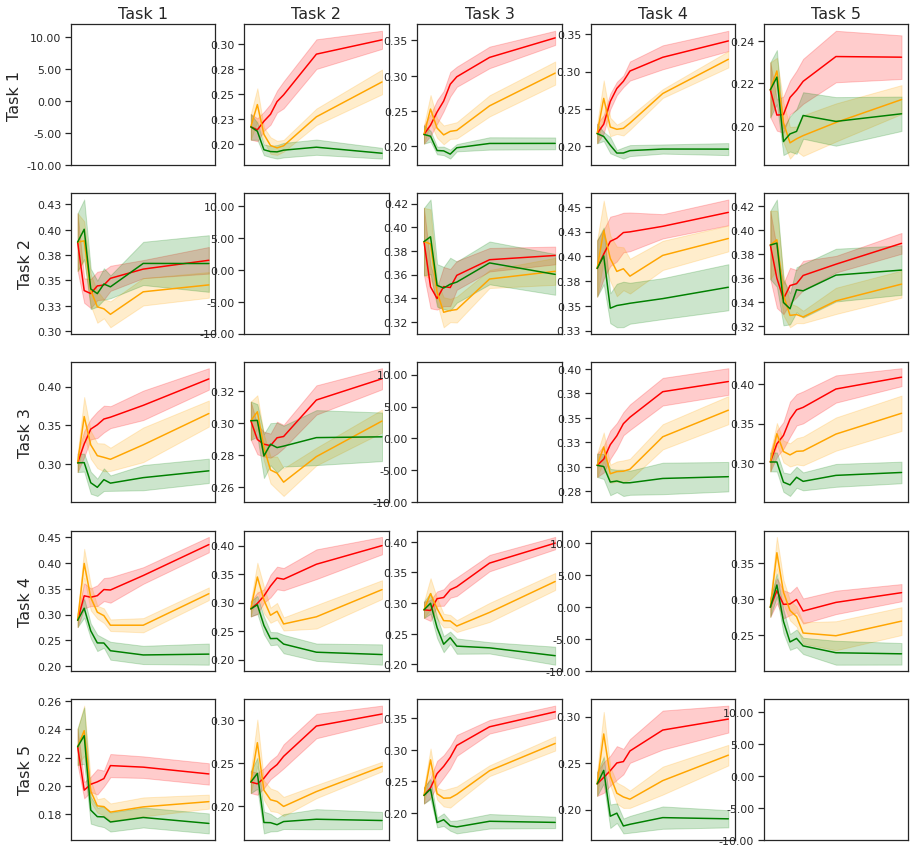

In [277]:
fontsize = 16
fig, axes = plt.subplots(5, 5, figsize=(15, 15), facecolor='white')
df_agnostic = df_agnostic.sort_values(by=['target', 'ood', 'm_n']).reset_index(drop=True)

for k, df in enumerate(dfs):
    df = df.sort_values(by=['target', 'ood', 'm_n']).reset_index(drop=True)

    for i in range(5):
        for j in range(5):
            ax = axes[i][j]
            ax.set_ylabel(" ")
            ax.grid(False)
            # ax.yaxis.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            if j == 0:
                ax.yaxis.set_visible(True)
                ax.set_ylabel("Task {}".format(i+1), fontsize=fontsize)
            if i == 0:
                ax.set_title("Task {}".format(j+1), fontsize=fontsize)
            if i == j: 
                ax.axis('off')
                if i == 0:
                    ax.axis('on')
                    ax.set_yticks([0.10, 0.30, 0.50])
                    ax.tick_params(axis='y', colors='white')
                    ax.set_ylabel("Task 1",fontsize=15)
                    ax.spines['top'].set_visible(False)
                    ax.spines['bottom'].set_visible(False)
                    ax.spines['right'].set_visible(False)
                    ax.spines['left'].set_visible(False)
                if j == 0:
                    ax.axis('on')
                    ax.yaxis.set_visible(False)
                    ax.set_xlim([1, 20])
                    ax.set_xticks([1, 10, 20])
                    ax.spines['top'].set_visible(False)
                    ax.spines['right'].set_visible(False)
                    ax.spines['left'].set_visible(False)
                continue

            dft = df[(df["target"]==i) & (df["ood"]==j)]
            if k==2 and len(np.unique(dft['device']))==2:
                avg_err = np.array(dft[(dft["target"]==i) & (dft["ood"]==j) & (dft["device"]=='cuda:3')]["avg_error"])
                std_err = np.array(dft[(dft["target"]==i) & (dft["ood"]==j) & (dft["device"]=='cuda:3')]["std_error"])
                m_n = np.array(dft[(dft["target"]==i) & (dft["ood"]==j) & (dft["device"]=='cuda:3')]["m_n"])
            else:
                avg_err = np.array(dft[(dft["target"]==i) & (dft["ood"]==j)]["avg_error"])
                std_err = np.array(dft[(dft["target"]==i) & (dft["ood"]==j)]["std_error"])
                m_n = np.array(dft[(dft["target"]==i) & (dft["ood"]==j)]["m_n"])

            if len(avg_err)==0:
                continue

            avg_err_ag = np.array(df_agnostic[(df_agnostic["target"]==i) & (df_agnostic["ood"]==j)]["avg_error"])
            std_err_ag = np.array(df_agnostic[(df_agnostic["target"]==i) & (df_agnostic["ood"]==j)]["std_error"])
            
            avg_err[0] = avg_err_ag[0]
            std_err[0] = std_err_ag[0]

            ci = 1.96 * std_err.astype('float')/np.sqrt(10)
            ax.plot(m_n, avg_err, c=colors[k])
            ax.fill_between(m_n, avg_err-ci, avg_err+ci, color=colors[k], alpha=0.2)
            # ax.set_ylim([0.10, 0.5])

            # ax.set_ylim([0.90, 1.01])
            # ax.set_yticks([0.9, 1.0])
            ax.set_xlim([1, 20])
            ax.set_xticks([1, 10, 20])

            if i == 4 and j == 2:
                ax.set_xlabel("m/n, n=100")
            else:
                ax.set_xlabel("")
            if i == 2 and j == 0:
                ax.set_ylabel('Target Generalization Error\n\nTarget Tasks\nTask 3', multialignment='center')
            if i == 0 and j == 2:
                ax.set_title('OOD Tasks\nTask 3', multialignment='center', fontsize=15)




In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(11, 7), facecolor='white')
for i in range(5):
    for j in range(5):
        ax.set_ylabel(" ")
        axs[i][j].grid(False)
        # axs[i][j].yaxis.set_visible(False)
        axs[i][j].xaxis.set_visible(False)
        axs[i][j].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        if i == 0:
            axs[i][j].set_title("Task {}".format(j+1), fontsize=15)
        if i == 4:
            axs[i][j].xaxis.set_visible(True)
        if j == 0:
            axs[i][j].yaxis.set_visible(True)
            axs[i][j].set_ylabel("Task {}".format(i+1), fontsize=15)
        if j == i:
            axs[i][j].axis('off')
            if i == 0: 
                axs[i][j].axis('on')
                axs[i][j].set_yticks([0.10, 0.30, 0.50])
                axs[i][j].tick_params(axis='y', colors='white')
                axs[i][j].set_ylabel("Task 1",fontsize=15)
                axs[i][j].spines['top'].set_visible(False)
                axs[i][j].spines['bottom'].set_visible(False)
                axs[i][j].spines['right'].set_visible(False)
                axs[i][j].spines['left'].set_visible(False)
            if j == 4:
                axs[i][j].axis('on')
                axs[i][j].yaxis.set_visible(False)
                axs[i][j].set_xlim([1, 20])
                axs[i][j].set_xticks([1, 10, 20])
                axs[i][j].spines['top'].set_visible(False)
                axs[i][j].spines['right'].set_visible(False)
                axs[i][j].spines['left'].set_visible(False)
            continue
        file = "task_matrix/T{}_T{}_Optimal_Task_Aware/cifar10_smallconv_singlehead_dual_tasks_T{}.csv".format(i+1, j+1, i+1)
        df = pd.read_csv(file)
        df = df.filter(["m", "r", "{}_alpha".format(j+1)])
        ax = sns.lineplot(data=df, x="m", y="{}_alpha".format(j+1), ax=axs[i][j], markers=True, color='r', lw=2.5)
        
        ax.set_ylim([0.90, 1.01])
        ax.set_yticks([0.9, 1.0])
        ax.set_xlim([1, 20])
        ax.set_xticks([1, 10, 20])
        # ax.set_xlim(ax.get_xlim())
        # ax.set_ylim([0.10, 0.50])
        # axs[i][j].set_yticks([0.10, 0.30, 0.50])
        if i == 4 and j == 2:
            ax.set_xlabel("m/n, n=100")
        else:
            ax.set_xlabel("")
        if i == 2 and j == 0:
            ax.set_ylabel('Optimal Alpha\n\nTarget Tasks\nTask 3', multialignment='center')
        if i == 0 and j == 2:
            ax.set_title('OOD Tasks\nTask 3', multialignment='center', fontsize=15)
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.2   # the amount of height reserved for white space between subplots
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
plt.show()

if save_fig:
    filename = "splitcifar_task_matrix_optimal_alpha"
    fig.savefig("./ECCV_workshop/figures/{}.pdf".format(filename), bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(11, 7), facecolor='white')
    for i in range(5):
        for j in range(5):
            axs[i][j].set_ylabel(" ")
            axs[i][j].grid(False)
            # axs[i][j].yaxis.set_visible(False)
            axs[i][j].xaxis.set_visible(False)
            axs[i][j].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            if i == 0:
                axs[i][j].set_title("Task {}".format(j+1), fontsize=15)
            if i == 4:
                axs[i][j].xaxis.set_visible(True)
            if j == 0:
                axs[i][j].yaxis.set_visible(True)
                axs[i][j].set_ylabel("Task {}".format(i+1), fontsize=15)
            if j == i:
                axs[i][j].axis('off')
                if i == 0: 
                    axs[i][j].axis('on')
                    axs[i][j].set_yticks([0.10, 0.30, 0.50])
                    axs[i][j].tick_params(axis='y', colors='white')
                    axs[i][j].set_ylabel("Task 1",fontsize=15)
                    axs[i][j].spines['top'].set_visible(False)
                    axs[i][j].spines['bottom'].set_visible(False)
                    axs[i][j].spines['right'].set_visible(False)
                    axs[i][j].spines['left'].set_visible(False)
                if j == 4:
                    axs[i][j].axis('on')
                    axs[i][j].yaxis.set_visible(False)
                    axs[i][j].set_xlim([0, 20])
                    axs[i][j].set_xticks([0, 10, 20])
                    axs[i][j].spines['top'].set_visible(False)
                    axs[i][j].spines['right'].set_visible(False)
                    axs[i][j].spines['left'].set_visible(False)
                continue
            file = "task_matrix/T{}_T{}_Task_Agnostic/cifar10_smallconv_singlehead_dual_tasks_T{}_T{}.csv".format(i+1, j+1, i+1, j+1)
            df = pd.read_csv(file)
            df = df.filter(["m", "r", str(j+1)])
            ax = sns.lineplot(data=df, x="m", y=str(j+1), ax=axs[i][j], markers=True, color='r', lw=2.5, label="Task-Agnostic Setting", legend=False)

            file = "task_matrix/T{}_T{}_Naive_Task_Aware/cifar10_smallconv_singlehead_dual_tasks_T{}_T{}.csv".format(i+1, j+1, i+1, j+1)
            df = pd.read_csv(file)
            df = df.filter(["m", "r", str(j+1)])
            ax = sns.lineplot(data=df, x="m", y=str(j+1), ax=axs[i][j], markers=True, color='orange', lw=2.5, label="Naive Task-Aware Setting", legend=False)

            file = "task_matrix/T{}_T{}_Optimal_Task_Aware/cifar10_smallconv_singlehead_dual_tasks_T{}_T{}.csv".format(i+1, j+1, i+1, j+1)
            df = pd.read_csv(file)
            df = df.filter(["m", "r", str(j+1)])
            ax = sns.lineplot(data=df, x="m", y=str(j+1), ax=axs[i][j], markers=True, color='g', lw=2.5, label="Optimal Task-Aware Setting", legend=False)
            
            # ax.set_ylim([0.10, 0.50])
            ax.set_yticks(ax.get_ylim())
            ax.set_xlim([0, 20])
            # ax.set_xscale("symlog", linthresh=10)
            ax.set_xlim(ax.get_xlim())
            # ax.set_ylim([0.10, 0.50])
            # axs[i][j].set_yticks([0.10, 0.30, 0.50])
            if i == 4 and j == 2:
                ax.set_xlabel("m/n, n=100")
            else:
                ax.set_xlabel("")
            if i == 2 and j == 0:
                ax.set_ylabel('Target Generalization Error\n\nTarget Tasks\nTask 3', multialignment='center')
            if i == 0 and j == 2:
                ax.set_title('OOD Tasks\nTask 3', multialignment='center', fontsize=15)
    left  = 0.125  # the left side of the subplots of the figure
    right = 0.9    # the right side of the subplots of the figure
    bottom = 0.13   # the bottom of the subplots of the figure
    top = 0.93      # the top of the subplots of the figure
    wspace = 0.4   # the amount of width reserved for blank space between subplots
    hspace = 0.2   # the amount of height reserved for white space between subplots
    plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
    plt.figlegend(handles=ax.get_lines(),
                loc=8,
                ncol=3,
                fontsize=12)
    plt.show()

### CIFAR-10 T2 vs. T5 multiple $n$

In [3]:
def get_results(tag):
    api = wandb.Api()
    runs = api.runs("ashwin1996/ood_tl")

    summary_list, config_list, name_list = [], [], []
    m_n = []
    avg_error = []
    std_error = []
    target = []
    ood = []
    gpu = []
    for run in runs: 
        try:
            run_tag = run.config['tag'] 
        except KeyError:
            run_tag = "None"
        if run_tag == tag:
            summary_list.append(run.summary._json_dict)
            config_list.append(
                {k: v for k,v in run.config.items()
                if not k.startswith('_')})
            name_list.append(run.name)
            m_n.append(run.config['task']['m_n'])
            avg_error.append(run.summary['avg_err'])
            std_error.append(run.summary['std_err'])
            target.append(run.config['task']['target'])
            ood.append(run.config['task']['ood'][0])
            gpu.append(run.config['device'])

    runs_df = pd.DataFrame({
        "target": target,
        "ood": ood,
        "m_n": m_n,
        "avg_error": avg_error,
        "std_error": std_error,
        "device": gpu,
        "summary": summary_list,
        "config": config_list,
        "name": name_list
        })

    return runs_df

In [7]:
df_50 = get_results("04_cifar10/wrn-10-2/n50")
df_100 = get_results("04_cifar10/wrn-10-2/n100")
df_200 = get_results("04_cifar10/wrn-10-2/n200")

In [19]:
dfs = [df_50, df_100, df_200]

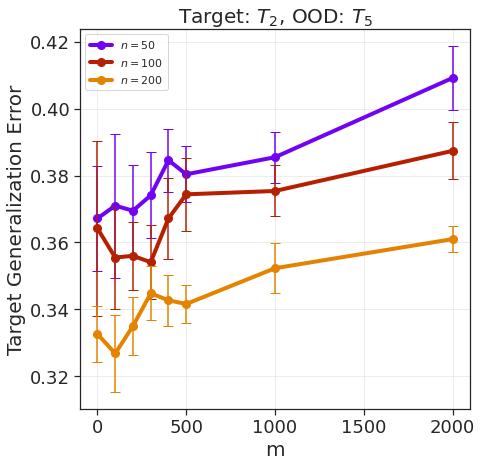

In [22]:
n_list = [50, 100, 200]
cmap = [plt.cm.gnuplot(i) for i in np.linspace(0.2, 0.8, len(n_list))]
fig, ax = plt.subplots(figsize=(7, 7))
reps = 10

for i, df in enumerate(dfs):
    df = df.sort_values(by=['m_n']).reset_index(drop=True)
    m = df['m_n'].to_numpy() * n_list[i]
    m = np.delete(m, [1, 2, 3])
    avg_error = df['avg_error'].to_numpy()
    avg_error = np.delete(avg_error, [1, 2, 3])
    std_error = df['std_error'].to_numpy()
    std_error = np.delete(std_error, [1, 2, 3])
    ci = 1.96 * std_error / np.sqrt(reps)
    ax.plot(m, avg_error , color=cmap[i], lw=lw, marker='o', markersize=markersize, label=r"$n = {}$".format(n_list[i]))
    ax.errorbar(m, avg_error, yerr=ci, color=cmap[i], solid_capstyle='projecting', capsize=5)
    ax.set_ylabel("Target Generalization Error", fontsize=fontsize)
    ax.set_xlabel("m", fontsize=fontsize)
    ax.set_title(r"Target: $T_2$, OOD: $T_5$", fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=labelsize)
    ax.tick_params(axis='y', labelsize=labelsize)
ax.legend()
# legend = ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", fontsize=labelsize, frameon=False, title="Blur Level\n     ($\sigma$)")
# legend.get_title().set_fontsize(fontsize)